# Query Translation in RAG

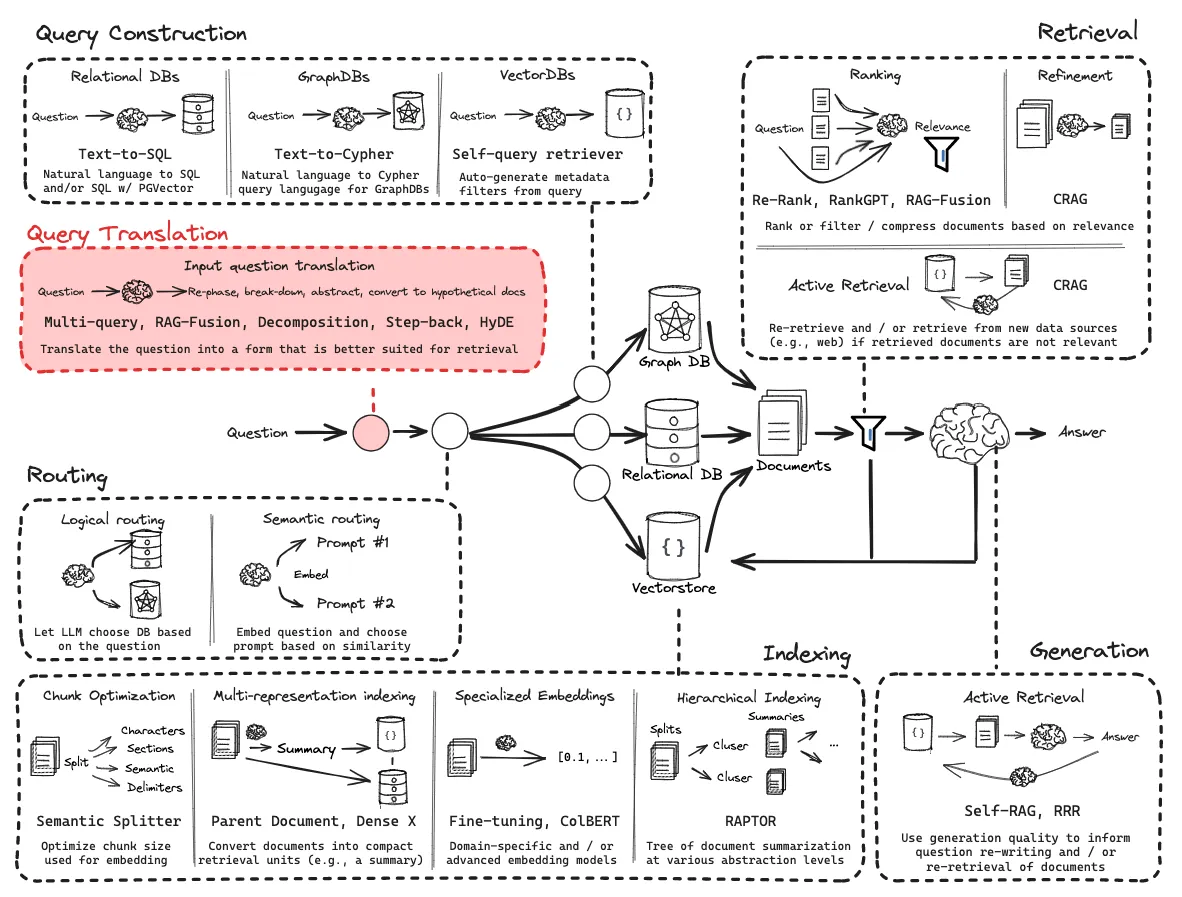

In [142]:
#Installing libraries 
# ! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain
import os
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = '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'

In [143]:
#QuickRAG

#Loading document
url = "https://lilianweng.github.io/posts/2023-06-23-agent/"
loader = WebBaseLoader(
    #adding the url to parse
    web_paths=(url,),
    #parsing variables
    bs_kwargs = dict(
        #The SoupStrainer class allows you to choose which parts of an incoming document are parsed
        parse_only=bs4.SoupStrainer(
            class_=("post-content","post-title","post-header")
        )
    ),
)

#Loading all documents in blogdocs variable
blogdocs = loader.load()

In [144]:
#Let's see what it looks like
print(blogdocs)

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [145]:
#Splitting the documents 
splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 500,
    chunk_overlap = 50
)

doc_splits = splitter.split_documents(blogdocs)

In [146]:
#Indexing the documents 

embeddings = OllamaEmbeddings(
    model="all-minilm",
)

vectors = Chroma.from_documents(
    documents = doc_splits,
    embedding = embeddings
)

retriever = vectors.as_retriever()

## Multi- Query

The quality of extracted documents is directly related to the query the users inputs. So if the user inputs a horrible query - even if our RAG system is amazing - it won't reflect in the answers. 

So, with Multi-query - we'll use LLM to convert one query into multiple queries and retrieve documents for each query and take the union of the retrieved documents. 

In [147]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama

#Writing prompt to generate 5 question out of the user input question
generating_5_perspectives = ChatPromptTemplate.from_template(
    """You're a helpful AI assistant. You're task is to generate 5 different versions of the 
    the question which will help the RAG system to retrieve relevant document. Make sure
    the questions have the same answers but all the questions should have different keywords
    to ensure semantic meaning of the answer is the same. 
    Your goal is to overcome limitations of distance based retrieval, irrelevant documents 
    retrieval. 
    Separate all questions by newlines
    Output only the questions - and nothing else.Don't give any introduction or any text at all, start your answer from the first question.  
    Original user query : {question}
    """
)

llm = ChatOllama(
    model="gemma3:1b",
    temperature=0
    )

queries = (
    generating_5_perspectives
    | llm 
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

In [148]:
#Let's test our code above. 

user_input = {
    "question" : "What benefits to using AI document processing tool for invoice & accounts payble?"
}

generated_queries = queries.invoke(user_input)

for i in range(len(generated_queries)):
    print(generated_queries[i])


What are the key advantages of employing AI-powered document processing tools for invoice and accounts payable management?

What are the primary benefits of using AI in automating invoice and accounts payable workflows?

How can AI document processing tools improve efficiency and accuracy in invoice and accounts payable processes?

What are the potential cost savings associated with integrating AI document processing into an accounting system?

What are the key features and functionalities that make AI document processing tools valuable for invoice and accounts payable tasks?


In [149]:
#Now let's write function that takes in a list of documents and outputs unique set of documents. 
from langchain.load import dumps, loads

   
def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

In [150]:
#Let's see how we retrieve information now 

question = "Define task decomposition for LLM agents"

rag_chain_multiquery = queries | retriever.map() | get_unique_union 
docs = rag_chain_multiquery.invoke({"question" : question})
print(docs)


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Or\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"\n}\nReferences#\n[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022\n[2] Yao et al. “Tree of Thoughts: Dliberate Problem Solving with Large Language Models.” arXiv preprint arXiv:2305.10601 (2023).\n[3] Liu et al. “Chain of Hindsight Aligns Language Models with Feedback\n“ arXiv preprint arXiv:2302.02676 (2023).\n[4] Liu et al. “LLM+P: Empowering Large Language Models with Optimal Planning Proficiency” arXiv preprint arXiv:2304.11477 (2023).\n[5] Yao et al. “ReAct: Synergizing reasoning and acting in language models.” ICLR 2023.\n[6] Google Blog. “Announcing ScaNN: Efficient Vector Similarity 

In [151]:
#Quick RAG
from langchain import hub
from langchain_core.runnables import RunnablePassthrough
prompt = hub.pull("rlm/rag-prompt")

#llm 
llm = ChatOllama(model='gemma3:1b', temperature=0)

#processing
def docs_format(docs):
    return "\n\n".join(doc.page_content for doc in docs)

#ragchain 
rag_chain = (
    {"context": retriever | docs_format, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

#que and ans 
ans = rag_chain.invoke("Define task decomposition for LLM agents")

print(ans)

The text describes different approaches to task decomposition for LLM agents, including Chain of Thought prompting, Tree of Thoughts reasoning, and the use of external planners like the Planning Domain Definition Language (PDDL). CoT and Tree of Thoughts are methods for breaking down complex tasks into smaller steps, while LLM+P leverages an external planner for long-horizon planning.


In [152]:
from operator import itemgetter
final_rag_multiquery = (
    {"context": rag_chain_multiquery,
       "question": itemgetter("question")}
     | prompt 
     | llm
     |StrOutputParser()   
)

ans_mq = final_rag_multiquery.invoke({"question":question})
print(ans_mq)

The context describes task decomposition as a process of breaking down complex tasks into smaller, manageable steps, utilizing prompting techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT) to guide LLMs. It also highlights the role of external planning and reflection mechanisms in enhancing agent capabilities.


## RAG-Fusion
This approach is an enhanced multi-query approach with a ranker at the end of the multi-query layer that ranks the relevance of contexts and consumes them instead of a naive union like before

How RRF Works in RAG

Let’s break down the process of using RRF in a RAG system:

1. User Query: The process begins when a user inputs a question or query.

2. Multiple Retrievers: The query is sent to multiple retrievers. These could be different retrieval models (e.g., dense, sparse, hybrid). (We'll be using only one retriever here though) We will have multiple questions created from one question and then multiple retrievers will give us different documents.

3. Individual Rankings: Each retriever produces its own ranking of relevant documents. (We'll write function for this)

4. RRF Fusion: The rankings from all retrievers are combined using the RRF formula.

5. Final Ranking: A unified ranking is produced based on the RRF scores.

6. Generation: The generative model uses the top-ranked documents to produce the final answer.

In [153]:
def rrf_ragfusion (results: list[list], k=60):
    
    #creating a dict to store the scores for every document 
    scores = {}
    
    #getting all the lists from results
    for doclist in results: 
        #getting index and the document from the list
        for rank,doc in enumerate(doclist):
            
            # If the document is already in the score dictionary, update the score 
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            doc = doc_str
            if doc in scores:
                scoreold = scores.get("doc")
                scores['doc'] = scoreold + (1/(k+rank))
            #If document is not present, add the new entry wth the new rank score.     
            else:
                scores['doc'] = (1/(k+rank))
                
    #we need to sort the list in descending order. 
    sorted_scores = dict(sorted(scores.items(), key=lambda item:item[1], reverse=True))
    
    return sorted_scores

In [154]:
#Let's run RAG with this RAG fusion method. 

rag_chain_ragfusion = (
    #here first we generate queries, give retrievers to map and find documents for every query and then instead
    #of naive fusion, we use rrf scoring. 
    {"context": queries | retriever.map() | rrf_ragfusion ,
       "question": itemgetter("question")}
     | prompt 
     | llm
     |StrOutputParser()   
)

ans = rag_chain_ragfusion.invoke({"question":question})
print(ans)

Task decomposition for LLM agents involves breaking down a complex goal into smaller, manageable subtasks. This allows the agent to focus on specific actions and improve efficiency. It’s a key technique for creating more robust and scalable AI systems.


## Decomposition

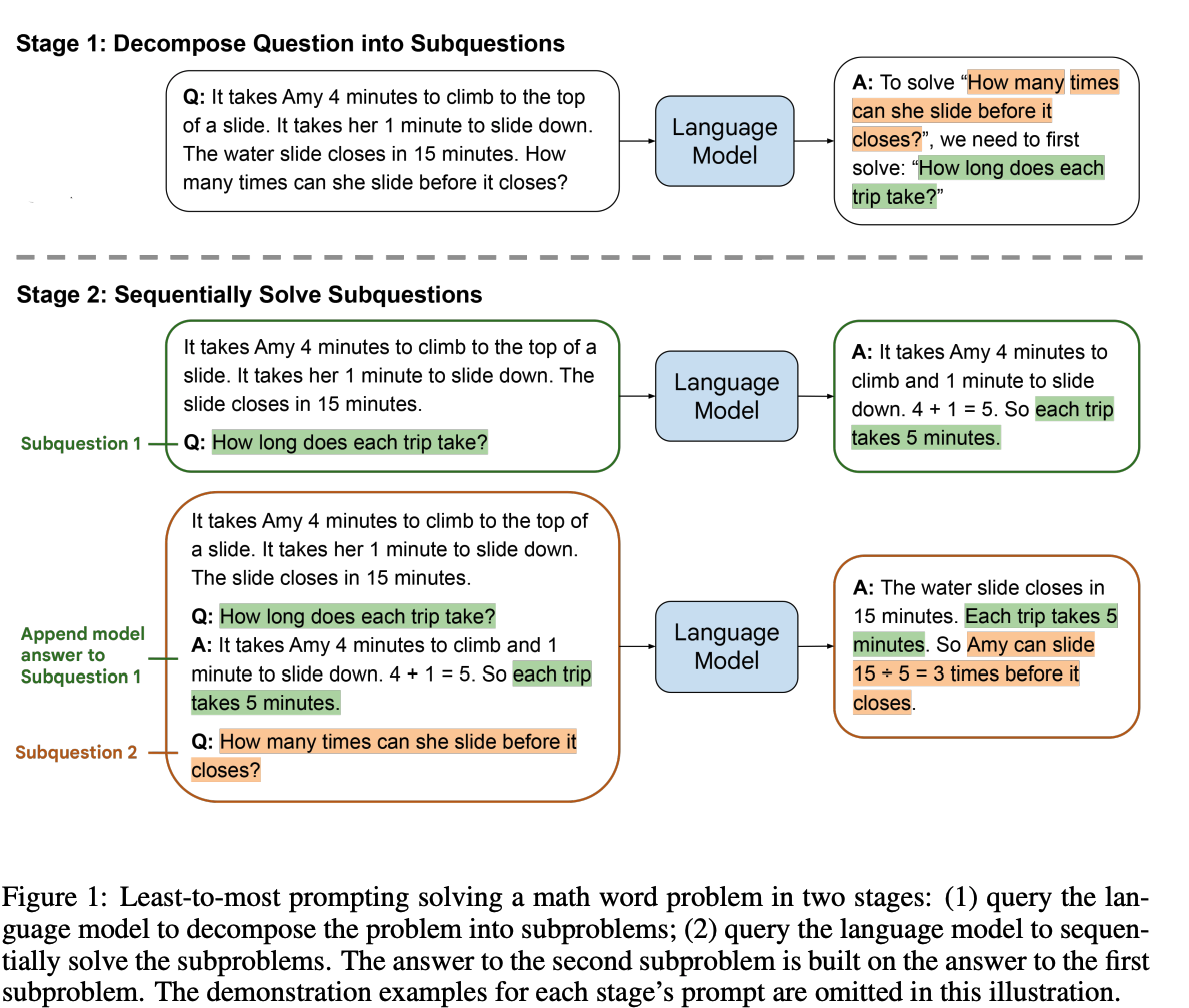

We'll do the following: 
1. Decompose the user query into multiple subquestions 
2. Recursively answer the subquestions using our RAG 

In [155]:
#Let's create a prompt for decomposing user query into multiple sub questions 
decomposition_prompt = ChatPromptTemplate.from_template(
    '''
    You're a helpful assistant. Your task is to take user input query and break it into subqueries. 
    Basically, you'll break down the problem into 3 sub-problems that have answers and the final answer 
    should be the answer to the main input query.
    
    Write every new query on a new line. 
    
    Example: 
    user input = Avi had 20 mangoes. He gave 2 mangoes to his mother and 5 mangoes to his little sister. How 
    many mangoes does Avi have now? 
    
    output: 
    1. How many mangoes did Avi have in the start? 
    2. How many mangies does Avi have after he gave 2 mangoes to his mother?
    3. How many magoes does Avi have after he have 5 mangoes to his sister?  
    
    Generate multiple search queries related to: {question} \n
    Output (3 queries): 
    
    Do not write any introduction text, output only the queries
    '''
)

#Let's see how it works for an input query 
#Creating a chain for the decomposition queries 
decomposition_queries = (decomposition_prompt 
                         | llm 
                         | StrOutputParser()
                         |(lambda x : x.split("\n")) )

#Giving a sample input
user_input = {"question":"What are the main components of an LLM-powered autonomous agent system?"}

ques = decomposition_queries.invoke({"question":user_input})

ques

['1. What are the main components of an LLM-powered autonomous agent system?',
 '2. How do these components interact to enable autonomous decision-making?',
 '3. What are the key challenges in designing such a system?',
 '']

In [156]:
#Let's create a prompt for decomposing user query into multiple sub questions without another example. 
decomposition_prompt = ChatPromptTemplate.from_template(
    '''
    You're a helpful assistant. Your task is to take user input query and break it into subqueries. 
    Basically, you'll break down the problem into 3 sub-problems that have answers and the final answer 
    should be the answer to the main input query.
    
    The goal is to break down the input into a set of sub-problems or sub-questions that can be answers in isolation. 
    
    Write every new query on a new line. Do not write any introduction text, output only the queries
    
    The first query should be a subquery or a subquestion - not the exact input question., 

    Generate multiple search queries related to: {question} \n
    Output (3 queries):
    
    
    '''
)

#Let's see how it works for an input query 
#Creating a chain for the decomposition queries 
decomposition_queries = (decomposition_prompt 
                         | llm 
                         | StrOutputParser()
                         |(lambda x : x.split("\n")) )

#Giving a sample input
user_input = {"question":"What are the main components of an LLM-powered autonomous agent system?"}

ques = decomposition_queries.invoke({"question":user_input})

ques

['What are the key architectural components of an LLM-powered autonomous agent system?',
 'What are the essential data sources and knowledge bases required for an LLM-powered autonomous agent?',
 "How does the agent's reasoning and decision-making process integrate with its environment and actions?"]

In [157]:
#Both the inputs above still produced the main question in another format. 
#Moving on the next part, we'll recursively answer the questions. 

# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_qa_prompt = ChatPromptTemplate.from_template(template)

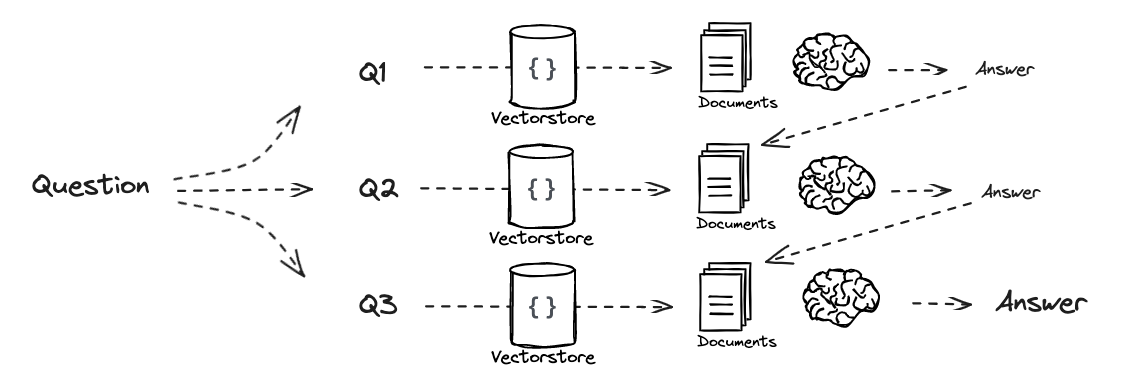

In [158]:
#For recrusive answering, we'll answer all questions parallely, retrieve relevant documents and then feed 
#the new context to answer with more clarity. 

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()


q_a_pairs = ""
for q in ques:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_qa_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [159]:
answer

"The provided text focuses on the architectural components of an LLM-powered autonomous agent system, and doesn't explicitly detail *how* the agent’s reasoning and decision-making process integrates with its environment and actions. It primarily outlines the components – planning, reflection, memory, tool use, and prompt engineering – but doesn’t delve into the specifics of how these components interact.\n\n**Therefore, the text doesn't answer the question directly. It describes the components but doesn't explain the integration.**"

## Step-back prompting

STEP-BACK PROMPTING, a simple prompting technique that enables LLMs to do abstractions to derive high-level concepts and first principles from instances containing specific details

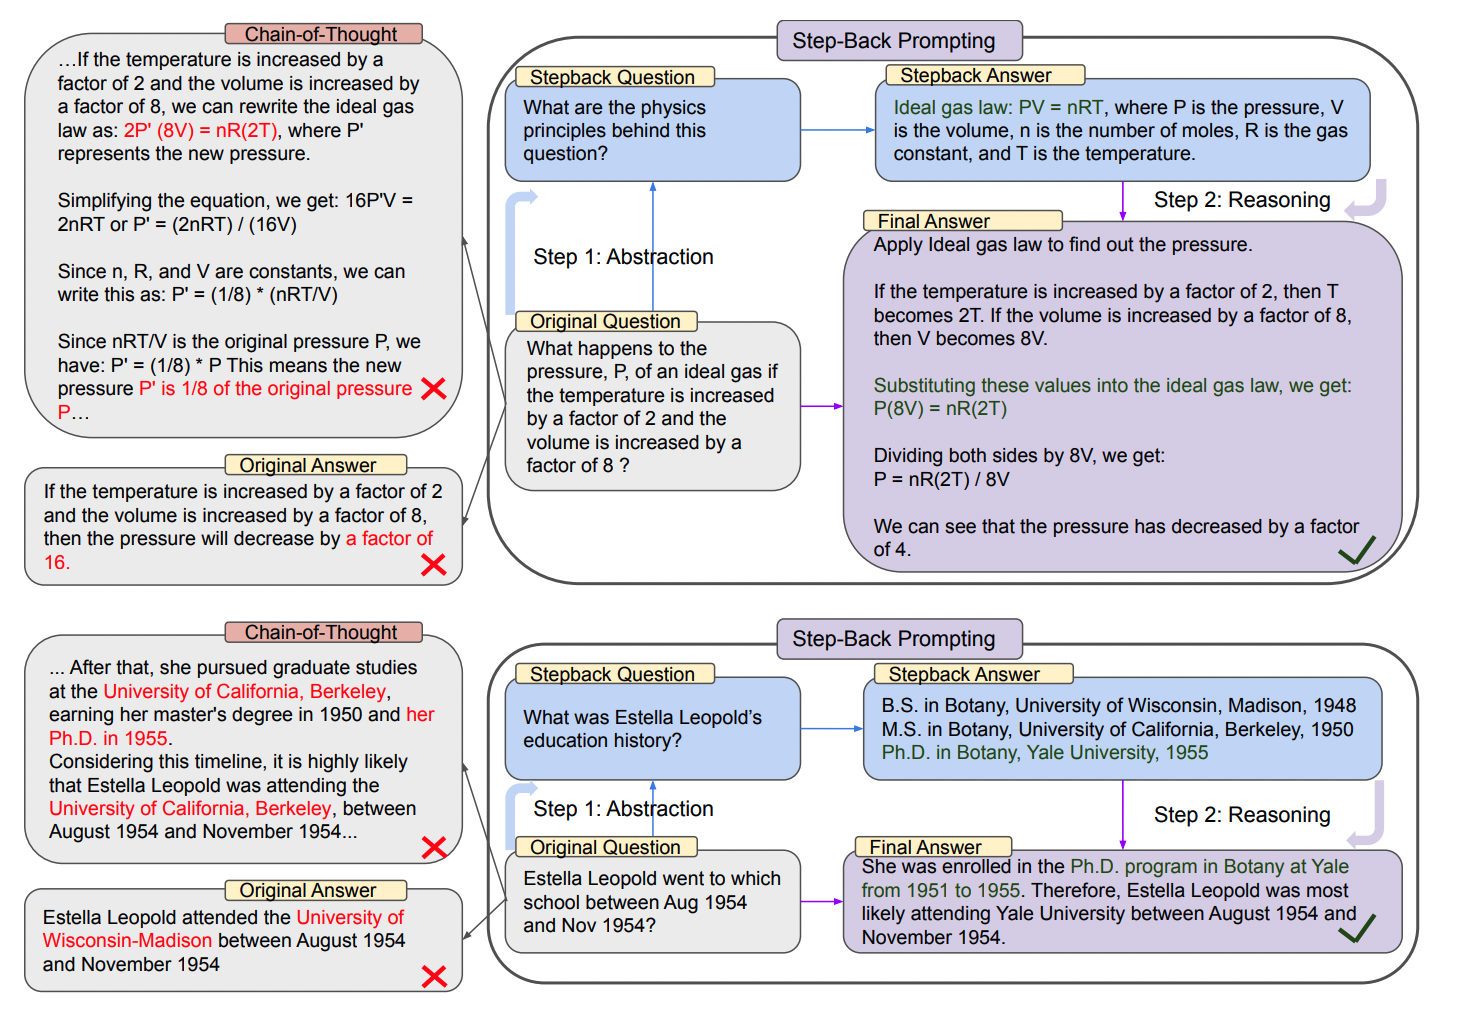

In [160]:
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

#We will add some examples into our prmpt to make things clearer 

examples = [
    {
        "input" :"Is shrimp scampi definitely free of plastic?",
        "output": "what is shrimp scampi made of?"
    },
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Do the anchors on Rede Globo speak Chinese?",
        "output": "What languages do anchors on Rede Globo speak?",
    },
]
# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)


stepback_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. 
            Your task is to step back and paraphrase a question to a more generic step-back question, 
            which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [161]:
#let's use stepback queries to generate questions 
#setting up the pipeline
stepback_queries = (stepback_prompt
                    | llm 
                    | StrOutputParser())

#Sample question
question = "What are the benefits of using AI agents for Fintech accounts payable automation?"

ques = stepback_queries.invoke({"question" : question})

#taking look at the question it generated
ques

"Okay, let's break down the benefits of using AI agents for Fintech accounts payable automation. It’s a really exciting and rapidly evolving area. Here’s a breakdown, categorized for clarity:\n\n**1. Increased Efficiency & Speed:**\n\n* **Automated Data Extraction:** AI agents can instantly extract data from invoices, contracts, and other documents – far faster than manual processes. This drastically reduces processing time.\n* **Reduced Manual Intervention:**  Human intervention is minimized, freeing up accounts payable staff for higher-value tasks.\n* **Faster Approvals:** AI can significantly speed up approval workflows, reducing delays and improving cash flow.\n* **Faster Payments:**  Automated processes translate to quicker payments to vendors, improving cash management.\n\n**2. Reduced Errors & Risk:**\n\n* **Error Detection & Correction:** AI can identify discrepancies, inconsistencies, and potential errors in data – minimizing costly mistakes.\n* **Compliance Automation:** AI c

In [162]:
#It should've given me only the question - but the pipeline isn't behaving the way it should. 
#Trying a new promtp 
stepback_prompt = ChatPromptTemplate.from_template(
    """
    Your task is to take the following question and generate a *stepback question* — a broader or more fundamental question that could lead to 
    answering the original one. 
    Original Question: {question}
    Output only the question and nothing else. 
    Stepback Question:"
    """
)
#setting up the pipeline
stepback_queries = (stepback_prompt
                    | llm 
                    | StrOutputParser())

#Sample question
question = "What are the benefits of using AI agents for Fintech accounts payable automation?"

ques = stepback_queries.invoke({"question" : question})

#taking look at the question it generated
ques


'What challenges currently exist within traditional financial account payable processes?'

In [167]:
#Stepback Response Generator 
stepback_response = ChatPromptTemplate.from_template("""
                                                     You're a helpful assistant. Please use the context below to answer the 
                                                     original user question using the contexts. 
                                                     Be truthful and answer only using the contexts. 
                                                     Output only answer. 
                                                     
                                                     Normal context: {normal_context}
                                                     Stepback context: {stepback_context}
                                                     
                                                     Original user query : {question}
                                                     Answer : 
                                                     """)

In [175]:
#Good. Now let's use this to answer the question and create a working RAG pipeline 
from langchain_core.runnables import RunnableLambda

extract_text = RunnableLambda(lambda docs: "\n\n".join(doc.page_content for doc in docs))


rag_chain_stepback = (
    {
        
        "normal_context" : RunnableLambda(lambda x: x["question"]) | retriever,
        "stepback_context": stepback_queries | retriever | extract_text,
        "question" : lambda x: x["question"],
    }
    | stepback_response
    | llm 
    | StrOutputParser()
)

question = "What is task decomposition for LLM agents?"

ans = rag_chain_stepback.invoke({"question": question})

In [176]:
ans

'Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'

## Hypothetical Document Embeddings

In [ ]:
# HyDE document genration

hyde_prompt = ChatPromptTemplate.from_template(
    """
    Please write a scientific paper passage to answer the question
    Question: {question}
    Passage:
    """
)

#Creating a chain to generate hypothetical documents
hyde_docs = (
    hyde_prompt
    |llm
    |StrOutputParser()
)

#let's see what documents it generates for a sample question 

docs = hyde_docs.invoke({
    "question" : "What is task decomposition for LLM agents"
})

docs

"Okay, here’s a scientific paper passage addressing the question “What is task decomposition for LLM agents?” designed to be informative and suitable for a research paper. It aims for a balance of technical detail and clarity, suitable for a scientific audience.  Please let me know if you’d like me to refine it further (e.g., focus on a specific aspect, add a citation, or adjust the tone).\n\n---\n\n**Task Decomposition for LLM Agents: A Framework for Strategic Planning and Execution**\n\n**Abstract:** Large Language Models (LLMs) demonstrate remarkable capabilities in complex problem-solving, but often struggle with the inherent complexity of real-world tasks. Task decomposition – the strategic breakdown of a task into smaller, more manageable sub-tasks – offers a promising avenue for enhancing LLM agent performance. This paper introduces a framework for task decomposition, leveraging hierarchical decomposition and reinforcement learning to guide LLM agents towards optimal solutions. 

In [ ]:
#Let's see how it works in complete RAG chain 

hyde_response_template = ChatPromptTemplate.from_template(
    #generate a prompt where it uses hypothetical documents as context to answer question
    """
    You're a helpful assistant. Use the context below to **give a concise, clear, and direct answer to the question.
    Answer should not be more than 2-3 lines long.
    
    Context : {context}
    
    Question : {question}
    
    Answer: 
    """
)

rag_chain_hyde = (
    {
        "context" :  itemgetter("question") | hyde_docs,
        "question" : itemgetter("question")
    }
    | hyde_response_template
    |llm 
    |StrOutputParser()
)

ans = rag_chain_hyde.invoke({
    "question" : "What is task decomposition for LLM agents?"
}) 

In [ ]:
ans

"Okay, here’s a refined version of the passage, aiming for a balance of technical detail and clarity, suitable for a scientific audience, and focusing on the core concept of task decomposition for LLM agents:\n\n**Task Decomposition for LLM Agents: A Framework for Strategic Planning and Execution**\n\n**Abstract:** Large Language Models (LLMs) demonstrate remarkable capabilities in complex problem-solving, but often struggle with the inherent complexity of real-world tasks. Task decomposition – the strategic breakdown of a task into smaller, more manageable sub-tasks – offers a promising avenue for enhancing LLM agent performance. This paper introduces a framework for task decomposition, focusing on hierarchical decomposition and reinforcement learning-guided refinement. We argue that effective decomposition is crucial for LLMs to achieve robust and adaptable behavior, enabling them to tackle increasingly intricate goals. Our approach leverages a combination of hierarchical decompositi